In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
# from transformers import AutoTokenizer

# model_path = "EleutherAI/qm-Llama-2-7b-hf-grader-last"
# tokenizer = AutoTokenizer.from_pretrained(model_path)

# # Tokens to decode
# tokens = [4986, 29907]
# tokenizer.decode(4986), tokenizer.decode(29907)

In [3]:
# layer, position, injection coefficient
# NOTE: there are no invalid elements (March 1st)
results = torch.load("steering_results.pt")

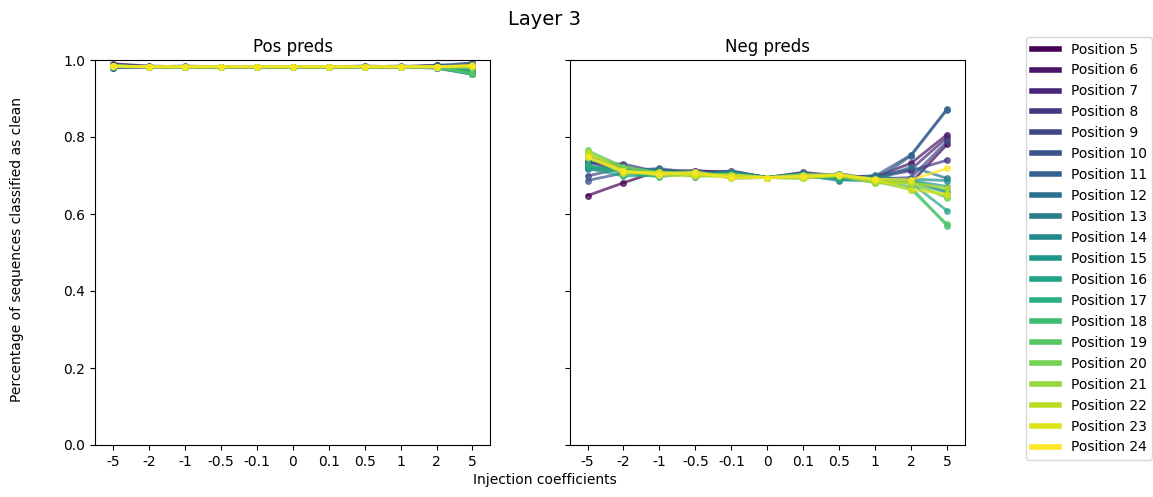

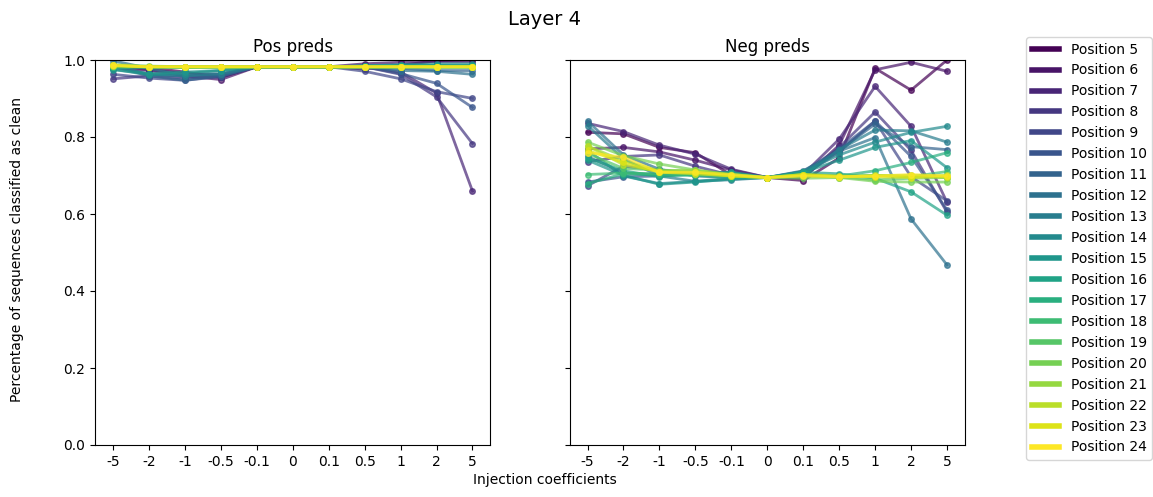

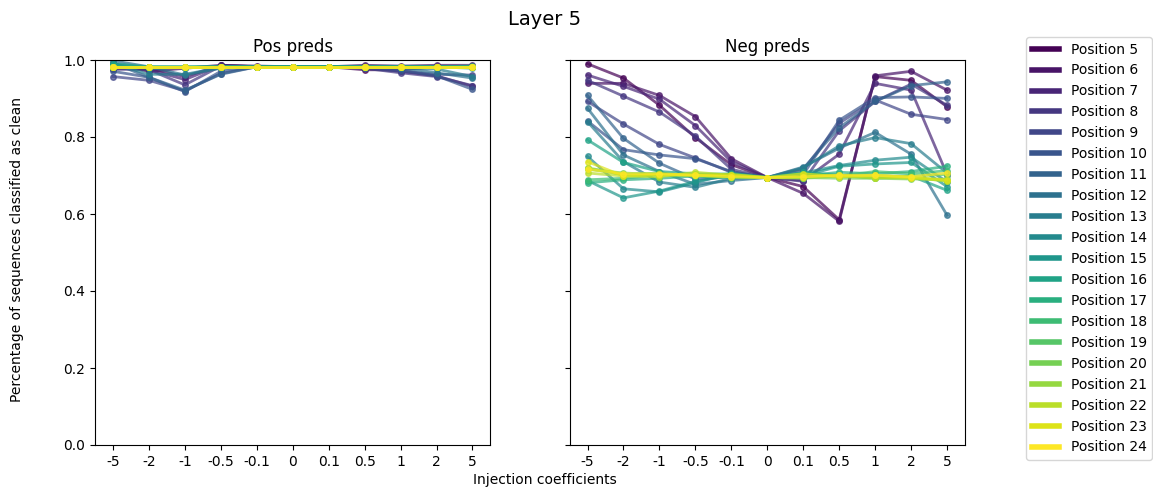

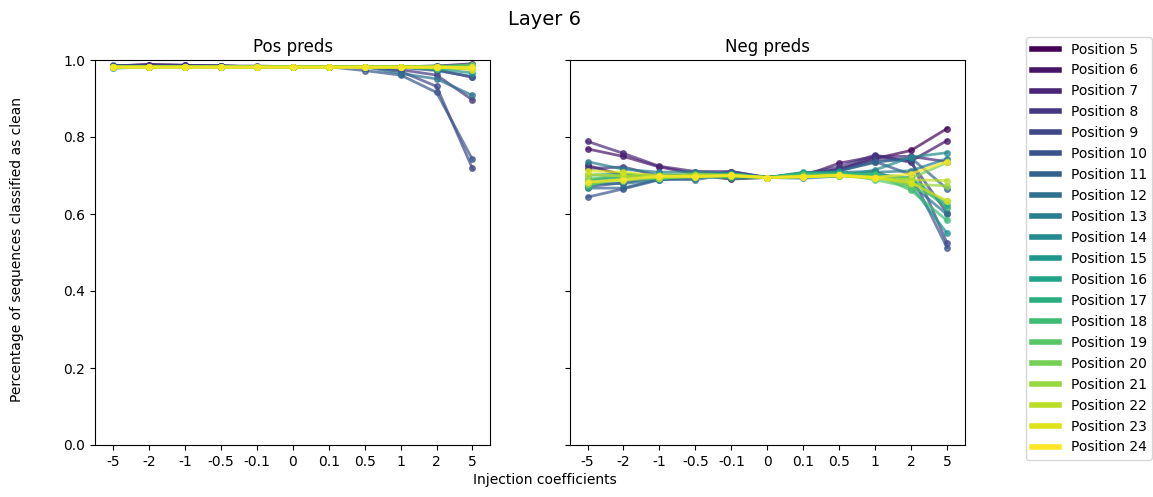

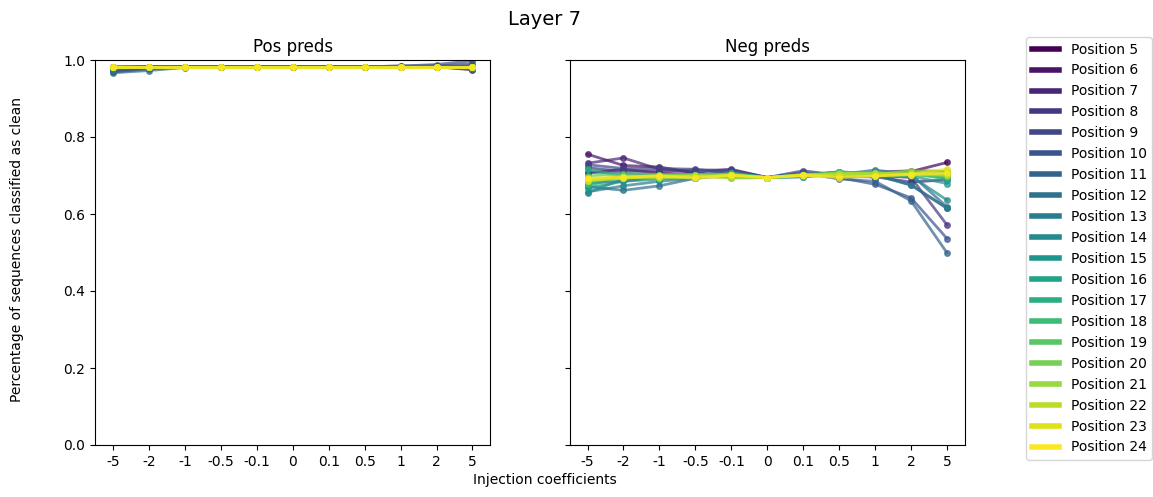

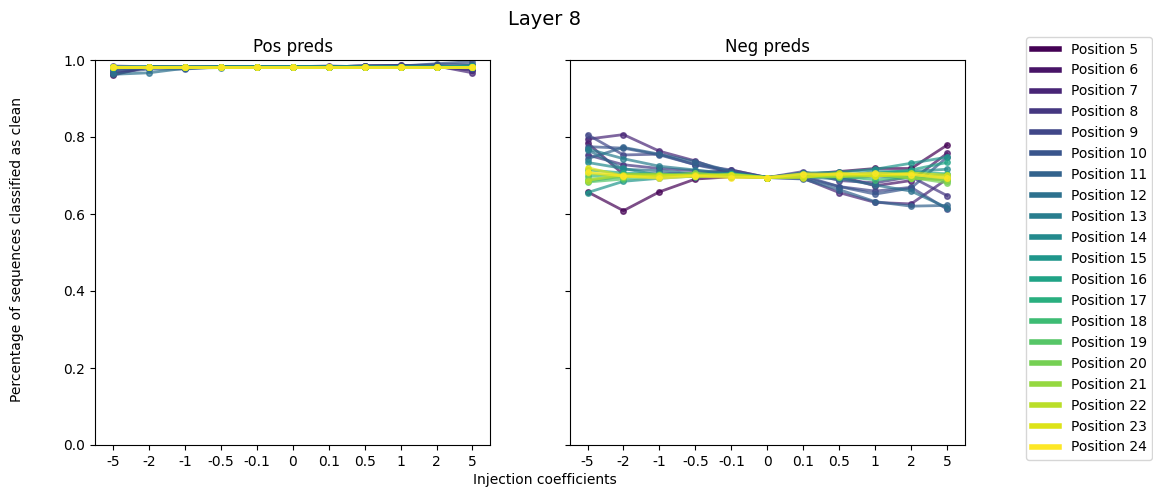

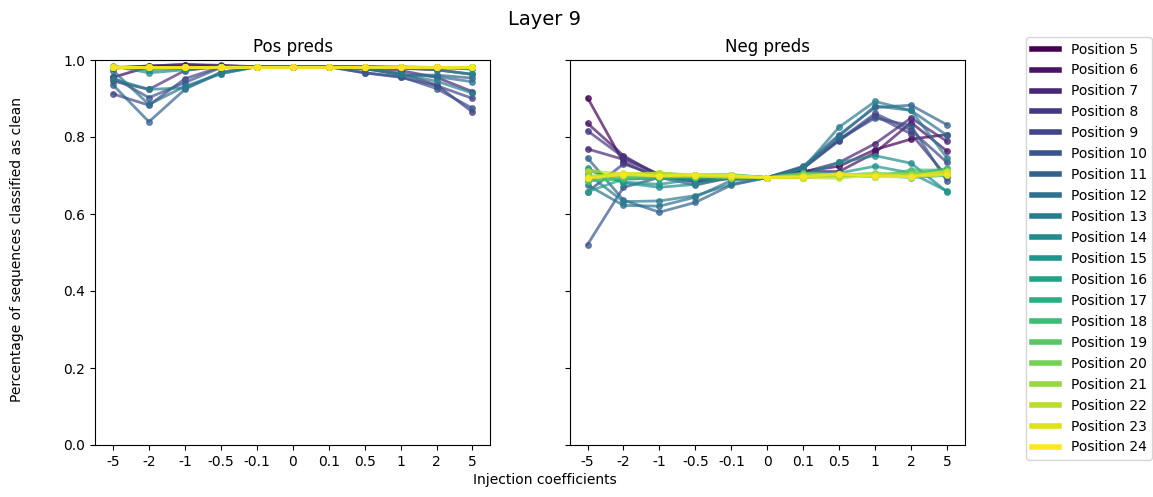

In [4]:

def get_counts(tensor):
    clean_count = (tensor == 29907).sum().item()
    toxic_count = (tensor == 4986).sum().item()
    invalid_count = tensor.numel() - clean_count - toxic_count

    if invalid_count != 0:
        raise ValueError("Invalid prediction during result generation!")

    return clean_count, toxic_count, invalid_count

ic_keys = ['-5', '-2', '-1', '-0.5', '-0.1', '0', '0.1', '0.5', '1', '2', '5']
total_count = results[3][5][0]["pos_preds"].numel()

# Generate a colormap
n_positions = len(results[3])
colors = cm.viridis(np.linspace(0, 1, n_positions))

for layer_key, layer in results.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    axes[0].set_ylim(0, 1)
    
    fig.suptitle(f"Layer {layer_key}", fontsize=14)
    fig.text(0.5, 0.04, 'Injection coefficients', ha='center', va='center')
    fig.text(0.06, 0.5, 'Percentage of sequences classified as clean', ha='center', va='center', rotation='vertical')

    for position_key, position in sorted(layer.items()):
        pos_clean_percentages = []
        neg_clean_percentages = []
        color = colors[position_key - 5]  # Assuming position_key starts at 5
        
        for ic_key, ic in position.items():
            clean_count, toxic_count, invalid_count = get_counts(ic["pos_preds"])
            pos_clean_percentages.append(clean_count / total_count)
            clean_count, toxic_count, invalid_count = get_counts(ic["neg_preds"])
            neg_clean_percentages.append(clean_count / total_count)

        axes[0].plot(ic_keys, pos_clean_percentages, label=f"Position {position_key}",
                      alpha=0.7, color=color, marker='o', linewidth=2, markersize=4)
        axes[1].plot(ic_keys, neg_clean_percentages, label=f"Position {position_key}",
                      alpha=0.7, color=color, marker='o', linewidth=2, markersize=4)

    axes[0].set_title("Pos preds")
    axes[1].set_title("Neg preds")
    axes[0].set_xticks(range(len(ic_keys)))
    axes[0].set_xticklabels(ic_keys)
    axes[1].set_xticks(range(len(ic_keys)))
    axes[1].set_xticklabels(ic_keys)

    # Create a custom legend outside the plot to make it more clear
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(n_positions)]
    fig.legend(custom_lines, [f"Position {i+5}" for i in range(n_positions)], loc='center right', borderaxespad=0.1)
    
    plt.subplots_adjust(right=0.85)
    plt.show()

    # Uncomment the following line if you want to display only the first layer
    # break
